In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time

# Constants setup
inWidth = 368
inHeight = 368
thr = 0.2
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4, "LShoulder": 5,
              "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9, "RAnkle": 10, "LHip": 11,
              "LKnee": 12, "LAnkle": 13, "REye": 14, "LEye": 15, "REar": 16, "LEar": 17}
POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

# Load the pre-trained model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") ## weights

In [2]:
img = cv.imread("pose.png")

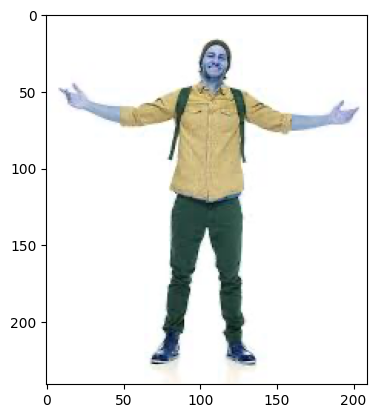

In [3]:
plt.imshow(img) #BGR (Blue Green and Red)

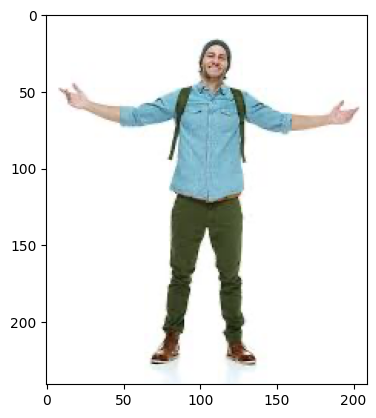

In [4]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [5]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # We only need the first 19 elements

    points = []
    point_details = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        if conf > thr:
            points.append((int(x), int(y)))
            point_details.append((list(BODY_PARTS.keys())[list(BODY_PARTS.values()).index(i)], (int(x), int(y)), True))
        else:
            points.append(None)
            point_details.append((list(BODY_PARTS.keys())[list(BODY_PARTS.values()).index(i)], (0, 0), False))

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return frame, point_details

In [6]:
estimated_image, joint_info = pose_estimation(img)

Nose: (109, 26), Visible
Neck: (104, 52), Visible
RShoulder: (90, 52), Visible
RElbow: (72, 57), Visible
RWrist: (27, 57), Visible
LShoulder: (122, 52), Visible
LElbow: (140, 62), Visible
LWrist: (154, 68), Visible
RHip: (90, 115), Visible
RKnee: (86, 167), Visible
RAnkle: (77, 209), Visible
LHip: (118, 115), Visible
LKnee: (118, 167), Visible
LAnkle: (122, 209), Visible
REye: (104, 26), Visible
LEye: (113, 26), Visible
REar: (99, 31), Visible
LEar: (113, 31), Visible



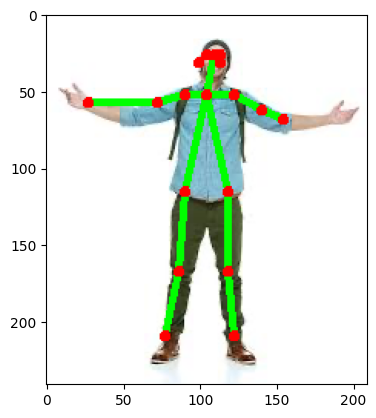

In [7]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
# Let's output the joint information as a text-based GUI representation
joint_gui = ""
for joint in joint_info:
    joint_name, coordinates, visible = joint
    visibility_status = "Visible" if visible else "Not Visible"
    joint_gui += f"{joint_name}: {coordinates}, {visibility_status}\n"

print(joint_gui)

# Perform this demo on video

In [8]:
cap = cv.VideoCapture('Screen Recording Sample.mp4') #VideoCapture is used for both webcam and videos
#optional settings
cap.set(3, 800) #3 is the index of the setting and 800 is the size/height
cap.set(4, 800) #now height and width is 800x800

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Video")

while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read() # reads the video frame by frame
    if not hasFrame: #if frame is corrupted/ video inside inside is corrupted, go for the next frame
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False)) ##grabbing the image, scaling, inwidth and inheight, 255/2, these are settings
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    #assert(len(BODY_PARTS) == out.shape[1]) # 18 body parts
    print("Output shape:", out.shape)
    print("Expected body parts:", len(BODY_PARTS))

    points = [] # list
    for i in range(min(len(BODY_PARTS), out.shape[1])): # Use min to avoid index errors
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    points = [] # list
    for i in range(len(BODY_PARTS)): # 18 body parts
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2] #find maximum amount of points (nose, shoulders, etc) then append
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None) #append no pair/join them
    #join the points
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        #after joining now draw 
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3) # lines are green (uses bgr, 0,0,0 is black, 255,255,255 white
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED) #points are red
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose estimation tutorial', frame) #name of video and print frame



Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18


2024-05-13 03:48:56.091 Python[75342:5429284] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46)
Expected body parts: 18
Output shape: (1, 19, 46, 46

KeyboardInterrupt: 

# Real time webcam demo

In [8]:
cap = cv.VideoCapture(0) #VideoCapture is used for both webcam and videos

#optional settings
cap.set(cv.CAP_PROP_FPS, 60) 
cap.set(3, 800) #3 is the index of the setting and 800 is the size/height
cap.set(4, 800) #now height and width is 800x800

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Webcam")

with open("joint_coordinates_log.txt", "w") as log_file:
    frame_number = 0
    start_time = time.time()

    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break

        # Calculate the timestamp relative to the start
        timestamp = time.time() - start_time
        milliseconds = int((timestamp - int(timestamp)) * 100)  # Calculate milliseconds

        frame, joint_info = pose_estimation(frame)
        
        #elapsed_time2 = time.time() - start_time
        timestamp_str = time.strftime("%H:%M:%S.", time.gmtime(timestamp)) + f"{milliseconds:02d}"
        cv.putText(frame, timestamp_str, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)  # White text for timer

        # Log joint information and display it on each frame
        for joint in joint_info:
            joint_name, coordinates, visible = joint
            if visible:
                # Create log message with frame number and timestamp
                log_message = f"Frame {frame_number}, {timestamp:.2f}s: {joint_name} coordinates: {coordinates}\n"
                print(log_message, end='')  # Print to terminal
                log_file.write(log_message)  # Write to file
                if len(log_message) > 0:  # Ensure the string is not empty to avoid errors
                    log_message_without_last = log_message[:-1]  # Slice to exclude the last character
                cv.putText(frame, log_message_without_last, (10, 50 + 20 * joint_info.index(joint)), cv.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 0), 2)
                # Overlay the joint information on the frame
                text = f"{joint_name}: {coordinates}"
                cv.putText(frame, text, coordinates, cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
                


        cv.imshow('Pose estimation with joint info', frame)

        frame_number += 1

cap.release()
cv.destroyAllWindows()

2024-05-13 03:49:26.713 Python[75388:5430179] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-05-13 03:49:28.583 Python[75388:5430179] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Frame 1, 0.23s: Nose coordinates: (910, 843)
Frame 1, 0.23s: Neck coordinates: (877, 1045)
Frame 1, 0.23s: RShoulder coordinates: (539, 1012)
Frame 1, 0.23s: LShoulder coordinates: (1147, 978)
Frame 1, 0.23s: REye coordinates: (809, 742)
Frame 1, 0.23s: LEye coordinates: (978, 742)
Frame 1, 0.23s: REar coordinates: (674, 776)
Frame 2, 0.33s: Nose coordinates: (910, 843)
Frame 2, 0.33s: Neck coordinates: (843, 1045)
Frame 2, 0.33s: RShoulder coordinates: (539, 1045)
Frame 2, 0.33s: LShoulder coordinates: (1147, 978)
Frame 2, 0.33s: REye coordinates: (809, 742)
Frame 2, 0.33s: LEye coordinates: (978, 742)
Frame 2, 0.33s: REar coordinates: (674, 742)
Frame 3, 0.46s: Nose coordinates: (910, 843)
Frame 3, 0.46s: Neck coordinates: (843, 1045)
Frame 3, 0.46s: RShoulder coordinates: (539, 1045)
Frame 3, 0.46s: LShoulder coordinates: (1180, 978)
Frame 3, 0.46s: REye coordinates: (809, 742)
Frame 3, 0.46s: LEye coordinates: (978, 742)
Frame 3, 0.46s: REar coordinates: (674, 742)
Frame 4, 0.56s: 

KeyboardInterrupt: 